## Feature Selection

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline
import os
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from dython.nominal import associations, numerical_encoding, cluster_correlations
from dython.data_utils import split_hist

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score, auc
from sklearn_evaluation import plot, table


In [19]:
sns.set_theme(style='whitegrid', palette='pastel')

In [20]:
data = pd.read_csv('../Capstone-Two/heartPHI2020.csv')
df = data.copy()
df.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


## Handling Imbalanced Data

After undersampling: Counter({'No': 27373, 'Yes': 27373})


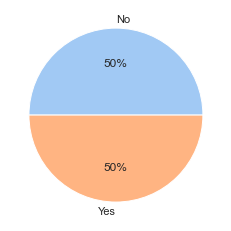

In [21]:
# Oversample and undersample and look at distributions.
# Undersample removes samples randomly from the majority class to make the distribution more equal
# As usual, X is all minus target variable
under_sampler = RandomUnderSampler(sampling_strategy=1, random_state=123)
X = df.iloc[:, 1:]
y = df['HeartDisease']
X_under, y_under = under_sampler.fit_resample(X, y)

# Count classes and create pie chart
print(f'After undersampling: {Counter(y_under)}')
plt.pie(y_under.value_counts(), labels = ['No', 'Yes'], autopct='%.0f%%');

After oversampling: Counter({'No': 292422, 'Yes': 292422})


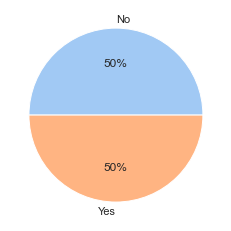

In [22]:
# oversampling randomly chooses and adds in samples from minority class to make distribution more equal
over_sampler = RandomOverSampler(sampling_strategy='minority', random_state=123)
X = df.iloc[:, 1:]
y = df['HeartDisease']
X_over, y_over = over_sampler.fit_resample(X, y)

print(f'After oversampling: {Counter(y_over)}')
plt.pie(y_over.value_counts(), labels = ['No', 'Yes'], autopct='%.0f%%');

In [23]:
# will move forward with undersampled df and explore oversampled df model performance later
y_under = pd.DataFrame(y_under)
undersampled_df = y_under.merge(X_under, left_index=True, right_index=True)
df = undersampled_df

## Preprocessing

In [24]:
# people with MentalHealth or PhysicalHealth response of 0, 
# responded that they had mental and physical problems 0 out of the last 30 days
df[['SleepTime', 'PhysicalHealth', 'MentalHealth']] = df[['SleepTime', 'PhysicalHealth', 'MentalHealth']].astype(int)

In [25]:
# similar to this study - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4877313/
# will evaluate, BMI PhysicalHealth, MentalHealth, and SleepTime as both continuous and categorical variables
# they used these bins for SleepTime of ≤ 6 h, > 6 to < 9 h, ≥ 9 h
# MentalHealth and PhysicalHealth variables are responses to how many days in last 30-31 were bad for health
# binning them by week
# Underweight: Less than 18.5, Healthy: 18.5 to 24.9, Overweight: 25 to 29.9, Class I obesity: 30 to 34.9, Class II obesity: 35 to 39.9, Class III obesity: More than 40.

sleep_bins = [-np.inf, 5, 7, 9, np.inf]
sleep_labels = ['≤ 5', '> 5 to ≤ 7 h', '> 7 to ≤ 9 h', '> 9 h']
df['SleepTime_binned'] = pd.cut(df['SleepTime'], bins=sleep_bins, labels=sleep_labels)

bmi_bins = [-np.inf, 18.49, 24.9, 29.9, 34.9, 39.9, np.inf]
bmi_labels = ['Underweight','Healthy','Overweight', 'Class I Obesity', 'Class II Obesity', 'Class III Obesity']
df['BMI_binned'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels)

mental_bins = [-np.inf, 7, 14, 21, np.inf]
mental_labels = ['≤ 7 days','8-14 days','15-21 days', '> 21 days']
df['MentalHealth_binned'] = pd.cut(df['MentalHealth'], bins=mental_bins, labels=mental_labels)

physical_bins = [-np.inf, 7, 14, 21, np.inf]
physical_labels = ['≤ 7 days','8-14 days','15-21 days', '> 21 days']
df['PhysicalHealth_binned'] = pd.cut(df['PhysicalHealth'], bins=physical_bins, labels=physical_labels)

In [26]:
agecat_mean = {'18-24':21,'25-29':27,'30-34':32,'35-39':37,'40-44':42,'45-49':47,'50-54':52,'55-59':57, 
                    '60-64':62,'65-69':67,'70-74':72,'75-79':77,'80 or older':80}

df['Mean_Age'] = df['AgeCategory'].apply(lambda x: agecat_mean[x])
df.drop(columns=['AgeCategory'],inplace=True)

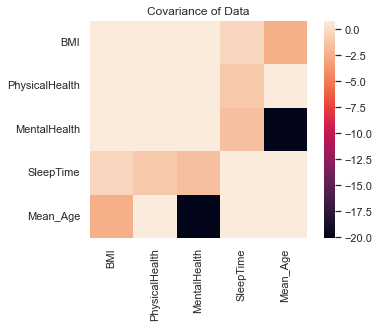

In [27]:
data_covariance = df.cov()
sns.heatmap(data_covariance, vmax=.8, square=True)
plt.title("Covariance of Data")
plt.show()

Encode and standardize data.

In [28]:
# label encode cols with 2 or less options
lencoder = LabelEncoder()
columns = ['Sex', 'HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 
           'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'PhysicalHealth']
for col in columns:
        df[col] = lencoder.fit_transform(df[col])
# onehot encode variables nunique > 2 -- model accuracies lower with onehot encoded 'AgeCategory'
df = pd.get_dummies(df, columns=['Race', 'Diabetic', 'GenHealth', 'SleepTime_binned', 'BMI_binned', 'MentalHealth_binned', 
                                 'PhysicalHealth_binned'], prefix=['Race', 'Diabetic', 'GenHealth', 'SleepTime_binned', 
                                                                   'BMI_binned', 'MentalHealth_binned', 'PhysicalHealth_binned'])


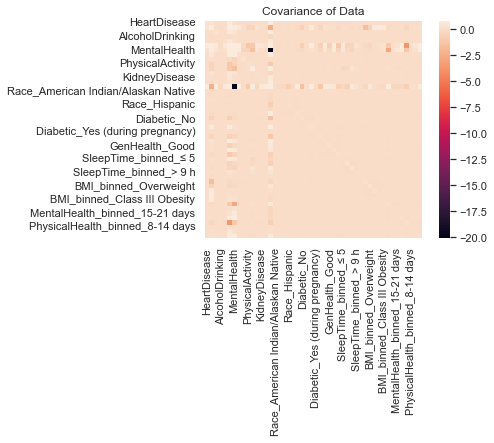

In [29]:
data_covariance = df.cov()
sns.heatmap(data_covariance, vmax=.8, square=True)
plt.title("Covariance of Data")
plt.show()

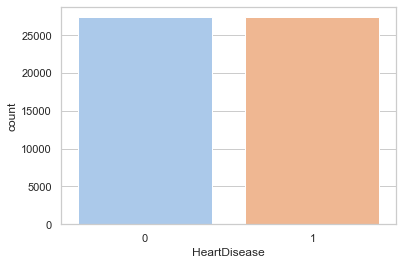

In [30]:
# train_test_split (before scaler)
X = df.iloc[:, 1:]
y = df['HeartDisease']

# confirm balance
sns.countplot(x=y, data=df)
plt.show()

In [31]:
len(X)

54746

In [32]:
df_corr = df.corr()['HeartDisease'].abs().sort_values(ascending=False)
df_corr

HeartDisease                           1.000000
Mean_Age                               0.441305
DiffWalking                            0.292866
Diabetic_Yes                           0.264561
Diabetic_No                            0.258449
GenHealth_Excellent                    0.246392
PhysicalHealth                         0.244809
PhysicalHealth_binned_≤ 7 days         0.236571
Stroke                                 0.232228
GenHealth_Fair                         0.217316
GenHealth_Poor                         0.209829
PhysicalHealth_binned_> 21 days        0.200893
Smoking                                0.191870
GenHealth_Very good                    0.191218
KidneyDisease                          0.184841
PhysicalActivity                       0.161174
SkinCancer                             0.140825
Sex                                    0.122945
BMI                                    0.094139
SleepTime_binned_> 5 to ≤ 7 h          0.091700
BMI_binned_Healthy                     0

In [33]:
# split data into train/test before scaling or tuning to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

Outliers

In [34]:
# outlier detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

lof = LocalOutlierFactor(p=1, n_jobs=-1)
yhat = lof.fit_predict(X_train)
# select all rows that are not outliers -- -1 is outlier 
mask = yhat != -1
X_train, y_train = X_train.iloc[mask], y_train.iloc[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

(38582, 47) (38582,)


In [35]:
num_removed = len(yhat) - np.count_nonzero(yhat==1)
num_removed

5214

Scaling

In [36]:
# separate numerical columns to be scaled
num_train_df = X_train[['BMI', 'PhysicalHealth','MentalHealth', 'SleepTime', 'Mean_Age']]
num_test_df = X_test[['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'Mean_Age']]

# fit scaler on training data and only transform test data
# scale after train_test_split to avoid causing data leakage
scaler = RobustScaler()

X_train_num = scaler.fit(num_train_df)
X_train_num = scaler.transform(num_train_df)
X_test_num = scaler.transform(num_test_df)

# Add column names and convert to df
col_names = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'Mean_Age']
X_train_num = pd.DataFrame(X_train_num, columns=col_names)
X_test_num = pd.DataFrame(X_test_num, columns=col_names)

In [37]:
# merge cat and num dataframes
X_train = X_train.drop(columns=['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'Mean_Age'])
X_train = X_train.reset_index(drop=True)
X_train = X_train.merge(X_train_num, left_index=True, right_index=True)

X_test = X_test.drop(columns=['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'Mean_Age'])
X_test = X_test.reset_index(drop=True)
X_test = X_test.merge(X_test_num, left_index=True, right_index=True)

## Feature selection

Tested LassoCV, RidgeCV, RFECV, and models selection methods

In [38]:
# feature selection with lasso regularization 
alphas = np.arange(0.1,10,0.1)
lassocv = LassoCV(alphas=alphas, random_state = 45)
lassocv.fit(X_train, y_train)

print(f'lassocv coef > 0 : {np.sum(lassocv.coef_ > 0)}')
feature_names = lassocv.feature_names_in_[lassocv.coef_ > 0]
print(f'features with lassocv coef > 0: {feature_names}')
print(f'alpha: {lassocv.alpha_}')
lasso_mse_path = lassocv.mse_path_
print(f'num features in: {lassocv.n_features_in_}')
print(f'score: {lassocv.score(X_test,y_test)}')

lassocv coef > 0 : 2
features with lassocv coef > 0: ['PhysicalHealth' 'Mean_Age']
alpha: 0.1
num features in: 47
score: 0.17791620238805728


After substituting mean_age for AgeCategory, Lasso suggests 2 features: ['PhysicalHealth' 'Mean_Age']

In [39]:
# feature selection with RidgeCV 
ridgecv = RidgeCV(alphas=alphas)
ridgecv.fit(X_train, y_train)

print(f'ridgecv coef > 0 : {np.sum(ridgecv.coef_ > 0)}')
sorted_coef = pd.Series(ridgecv.coef_).sort_values(ascending=False)
feature_names = ridgecv.feature_names_in_[sorted_coef.index]
print(f'sorted order (large to small) of ridgecv coef > 0: \n{feature_names}')
print(f'num features in: {ridgecv.n_features_in_}')
print(f'score: {ridgecv.score(X_test,y_test)}')
print(f'best score: {ridgecv.best_score_}')
magnitude_order_series = pd.Series(np.abs(list(ridgecv.coef_))).sort_values(ascending=False)
idx = magnitude_order_series.index
magnitude_order = ridgecv.feature_names_in_[idx]
print(f'top 20 magnitude order of abs(ridgecv coef) > 0: \n{magnitude_order[0:20]}')
print(f'bottom 10 magnitude order of abs(ridgecv coef) > 0: \n{magnitude_order[-21:-1]}')

ridgecv coef > 0 : 29
sorted order (large to small) of ridgecv coef > 0: 
['Mean_Age' 'Stroke' 'GenHealth_Poor' 'Sex' 'GenHealth_Fair'
 'KidneyDisease' 'Diabetic_Yes' 'Smoking' 'DiffWalking' 'Asthma'
 'PhysicalHealth_binned_≤ 7 days' 'Race_Other'
 'MentalHealth_binned_> 21 days' 'PhysicalHealth_binned_8-14 days'
 'PhysicalHealth' 'BMI_binned_Class III Obesity' 'SkinCancer' 'Race_White'
 'SleepTime_binned_≤ 5' 'BMI_binned_Class II Obesity'
 'Diabetic_No, borderline diabetes' 'GenHealth_Good'
 'MentalHealth_binned_15-21 days' 'BMI_binned_Class I Obesity'
 'SleepTime_binned_> 9 h' 'Race_American Indian/Alaskan Native'
 'PhysicalActivity' 'Race_Hispanic' 'PhysicalHealth_binned_15-21 days'
 'SleepTime_binned_> 7 to ≤ 9 h' 'BMI_binned_Overweight'
 'MentalHealth_binned_8-14 days' 'BMI' 'MentalHealth' 'SleepTime'
 'BMI_binned_Healthy' 'Race_Black' 'SleepTime_binned_> 5 to ≤ 7 h'
 'BMI_binned_Underweight' 'Diabetic_No' 'MentalHealth_binned_≤ 7 days'
 'Race_Asian' 'Diabetic_Yes (during pregnancy

## Features groupings to test

In [40]:
# Mean_Age only
age_X_train = X_train[['Mean_Age']]
age_X_test = X_test[['Mean_Age']]

In [41]:
# lasso chosen features
lasso_X_train = X_train[['Mean_Age', 'PhysicalHealth']]
lasso_X_test = X_test[['Mean_Age', 'PhysicalHealth']]

In [42]:
# RFECV features
RFElr_X_train = X_train[['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'Asthma',
       'KidneyDisease', 'SkinCancer', 'Race_Asian', 'Race_Black', 'Race_White',
       'Diabetic_No', 'Diabetic_Yes', 'GenHealth_Excellent', 'GenHealth_Fair',
       'GenHealth_Poor', 'GenHealth_Very good',
       'SleepTime_binned_> 5 to ≤ 7 h', 'SleepTime_binned_> 7 to ≤ 9 h',
       'BMI_binned_Healthy', 'BMI_binned_Class I Obesity',
       'MentalHealth_binned_≤ 7 days', 'PhysicalHealth_binned_≤ 7 days', 'BMI',
       'SleepTime', 'Mean_Age']]
RFElr_X_test = X_test[['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'Asthma',
       'KidneyDisease', 'SkinCancer', 'Race_Asian', 'Race_Black', 'Race_White',
       'Diabetic_No', 'Diabetic_Yes', 'GenHealth_Excellent', 'GenHealth_Fair',
       'GenHealth_Poor', 'GenHealth_Very good',
       'SleepTime_binned_> 5 to ≤ 7 h', 'SleepTime_binned_> 7 to ≤ 9 h',
       'BMI_binned_Healthy', 'BMI_binned_Class I Obesity',
       'MentalHealth_binned_≤ 7 days', 'PhysicalHealth_binned_≤ 7 days', 'BMI',
       'SleepTime', 'Mean_Age']]

In [43]:
# Log Reg Lasso model chosen features
lowzeroimportance_features = ['Race_White', 'BMI_binned_Class I Obesity','PhysicalActivity','PhysicalHealth', 'BMI_binned_Overweight',
                 'SleepTime_binned_≤ 5','MentalHealth_binned_> 21 days', 'MentalHealth_binned_15-21 days', 'PhysicalHealth_binned_8-14 days',
                 'MentalHealth_binned_8-14 days','PhysicalHealth_binned_> 21 days','SleepTime_binned_> 9 h','BMI',
                 'Race_Other','BMI_binned_Class III Obesity','BMI_binned_Class II Obesity','Race_Hispanic','BMI_binned_Underweight',
                 'MentalHealth','Race_American Indian/Alaskan Native','GenHealth_Good','Diabetic_Yes (during pregnancy)',
                 'Diabetic_No, borderline diabetes','PhysicalHealth_binned_15-21 days','BMI_binned_Healthy']
d_train = X_train.copy()
d_test = X_test.copy()
important_X_train = d_train.drop(columns=lowzeroimportance_features)
important_X_test = d_test.drop(columns=lowzeroimportance_features)

In [44]:
xgb_X_train = X_train[['Stroke', 'DiffWalking', 'Sex', 'Diabetic_No', 'Diabetic_Yes',
                       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good', 
                       'GenHealth_Poor', 'GenHealth_Very good', 'Mean_Age']]
xgb_X_test = X_test[['Stroke', 'DiffWalking', 'Sex', 'Diabetic_No', 'Diabetic_Yes',
                      'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
                      'GenHealth_Poor', 'GenHealth_Very good', 'Mean_Age']]

In [45]:
# Random Forest selected features
rf_15_train = X_train[['Mean_Age', 'DiffWalking', 'GenHealth_Excellent',
                        'PhysicalHealth', 'Stroke', 'Diabetic_Yes', 'BMI',
                        'Diabetic_No', 'GenHealth_Fair', 'Sex', 'PhysicalHealth_binned_≤ 7 days',
                       'GenHealth_Very good', 'Smoking', 'GenHealth_Poor', 'MentalHealth']]
rf_15_test = X_test[['Mean_Age', 'DiffWalking', 'GenHealth_Excellent',
                        'PhysicalHealth', 'Stroke', 'Diabetic_Yes', 'BMI',
                        'Diabetic_No', 'GenHealth_Fair', 'Sex', 'PhysicalHealth_binned_≤ 7 days',
                     'GenHealth_Very good', 'Smoking', 'GenHealth_Poor', 'MentalHealth']]

## Modeling

**Logistic Regression**

In [46]:
# out of the box logistic regression model for benchmark
# starting off simple with a linear model - LogReg
lr = LogisticRegression(random_state=123, max_iter=300)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('LogReg1 no penalty model: \n')
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Classification report: \n{classification_report(y_test, y_pred, digits=5)}')

y_hat = lr.predict(X_train)
print(f'LogReg training set accuracy: {accuracy_score(y_train, y_hat)}')
print(f'LogReg test set accuracy: {accuracy_score(y_test, y_pred)}')

LogReg1 no penalty model: 

Confusion matrix: 
[[4193 1390]
 [1119 4248]]
Classification report: 
              precision    recall  f1-score   support

           0    0.78934   0.75103   0.76971      5583
           1    0.75346   0.79150   0.77201      5367

    accuracy                        0.77087     10950
   macro avg    0.77140   0.77127   0.77086     10950
weighted avg    0.77176   0.77087   0.77084     10950

LogReg training set accuracy: 0.7672489762065212
LogReg test set accuracy: 0.7708675799086758


In [47]:
# Logistic Regression with l1 regularization (Lasso) 
lr2 = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear', scoring='accuracy', cv=StratifiedKFold(5), random_state=45, n_jobs=-1)
lr2 = lr2.fit(X_train, y_train)
y_pred2 = lr2.predict(X_test)

print('LogReg2 Lasso model: \n')
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred2)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred2, digits=5)}')

# model evaluation against test set
y_hat = lr2.predict(X_train)
print(f'LogReg2 training set accuracy: {accuracy_score(y_train, y_hat)}')
print(f'LogReg2 test set accuracy: {accuracy_score(y_test, y_pred2)}')

LogReg2 Lasso model: 

Confusion matrix: 
[[4190 1393]
 [1108 4259]]

Classification report: 
              precision    recall  f1-score   support

           0    0.79086   0.75049   0.77015      5583
           1    0.75354   0.79355   0.77303      5367

    accuracy                        0.77160     10950
   macro avg    0.77220   0.77202   0.77159     10950
weighted avg    0.77257   0.77160   0.77156     10950

LogReg2 training set accuracy: 0.7674822456067596
LogReg2 test set accuracy: 0.7715981735159817


In [48]:
# used RFECV to compute best iterations of 20 and 25 features, 
# then using cross-validation. Did not come up with higher accuracy models
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
simplefilter(action='ignore', category='UndefinedMetricWarning')

#lr2 = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear', scoring='precision', cv=5, random_state=45)
min_features_to_select=1
rfecv = RFECV(lr2, min_features_to_select=min_features_to_select, step=1, cv=StratifiedKFold(5),
    scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train, y_train)
rfecv_feature_names_out = rfecv.get_feature_names_out()
status = rfecv.support_
rankings = rfecv.ranking_
best_features =  X_train[rfecv_feature_names_out]
print("Optimal number of features : %d" % rfecv.n_features_)
print(f'RFE selected features: \n{best_features.columns}')


Optimal number of features : 37
RFE selected features: 
Index(['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',
       'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer',
       'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White',
       'Diabetic_No', 'Diabetic_Yes', 'GenHealth_Excellent', 'GenHealth_Fair',
       'GenHealth_Poor', 'GenHealth_Very good', 'SleepTime_binned_≤ 5',
       'SleepTime_binned_> 5 to ≤ 7 h', 'SleepTime_binned_> 7 to ≤ 9 h',
       'BMI_binned_Healthy', 'BMI_binned_Overweight',
       'BMI_binned_Class I Obesity', 'BMI_binned_Class II Obesity',
       'BMI_binned_Class III Obesity', 'MentalHealth_binned_≤ 7 days',
       'MentalHealth_binned_15-21 days', 'PhysicalHealth_binned_≤ 7 days',
       'PhysicalHealth_binned_> 21 days', 'BMI', 'PhysicalHealth',
       'MentalHealth', 'SleepTime', 'Mean_Age'],
      dtype='object')


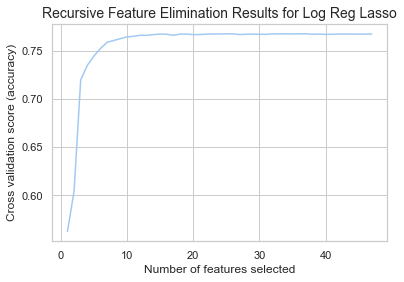

In [49]:
# plot RFECV cv_scores_
plt.figure()
plt.title('Recursive Feature Elimination Results for Log Reg Lasso', fontsize=14)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(min_features_to_select, 
               (len(rfecv.cv_results_['mean_test_score']) + min_features_to_select)),
         rfecv.cv_results_['mean_test_score'],)
plt.show()

In [50]:
# RFECV LogReg2 says best number of features 26, but graph looks more like 15. Test it 

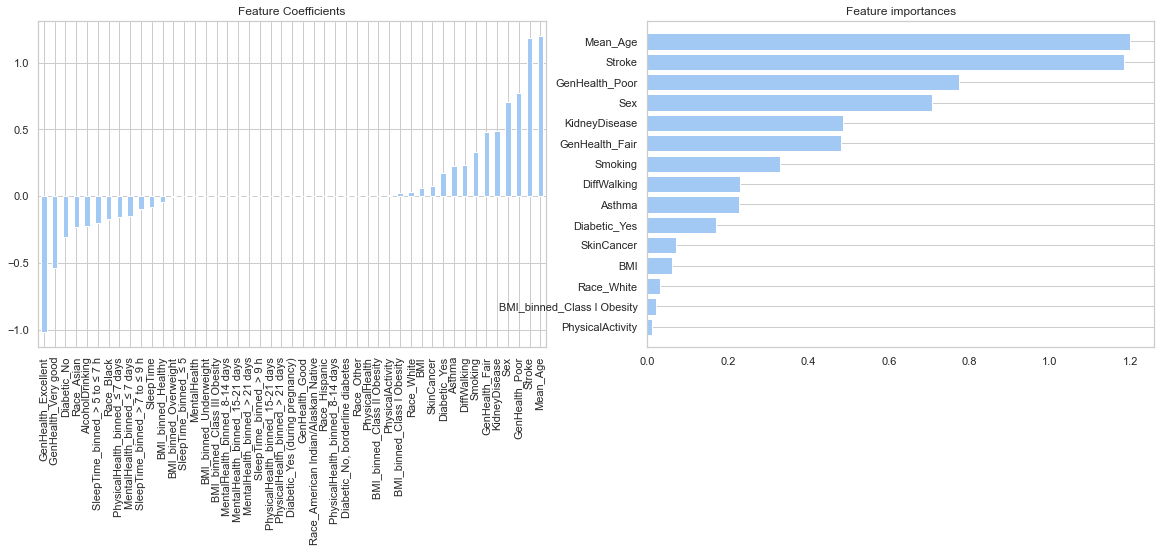

In [51]:
# plot feature coefficients representing feature importance
feature_names = list(lr2.feature_names_in_)
coef_ = lr2.coef_[0]
coef = pd.Series(coef_, feature_names)
fig, ax = plt.subplots(1,2,figsize=(20,6))
coef.sort_values().plot(kind='bar', title='Feature Coefficients', ax=ax[0])

# plot absolute value of coefficients 
# according to scikit documentation, model.coef_[0] is used to get the importance of the feature.
plot.feature_importances(coef_, top_n=15, feature_names=feature_names, ax=ax[1])
plt.show()

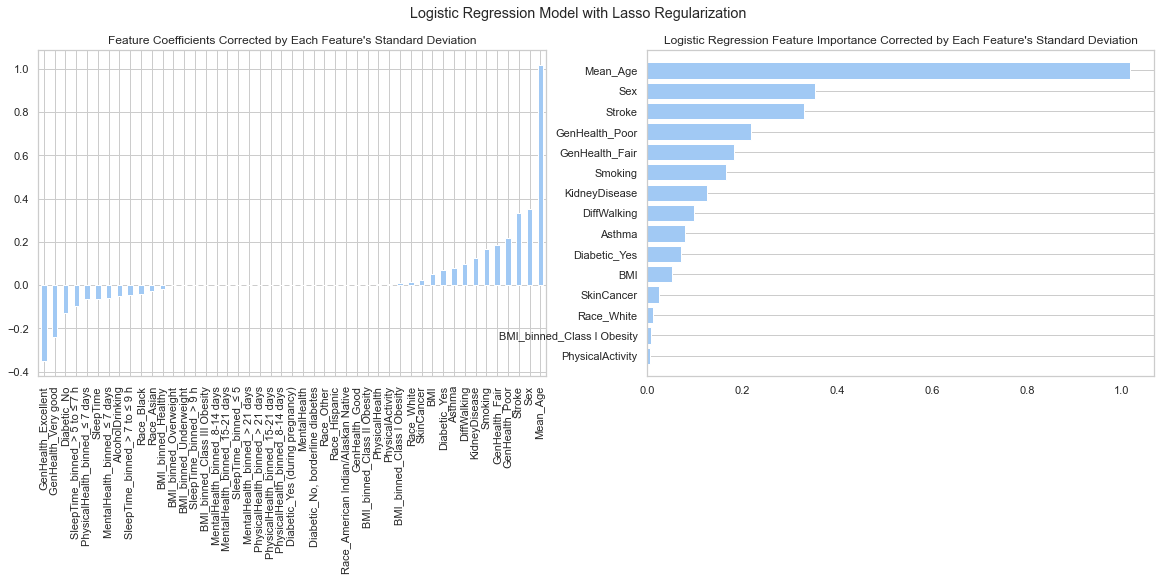

In [52]:
# plot feature coefficients representing feature importance -- after scaling/correcting with standard deviation
feature_names = list(lr2.feature_names_in_)
coef_ = lr2.coef_[0]
coef = pd.Series(coef_* X_train.std(axis=0), feature_names)
fig, ax = plt.subplots(1,2,figsize=(20,6))
plt.suptitle("Logistic Regression Model with Lasso Regularization")
coef.sort_values().plot(kind='bar', title="Feature Coefficients Corrected by Each Feature's Standard Deviation", ax=ax[0])

# plot absolute value of coefficients 
# according to scikit documentation, model.coef_[0] is used to get the importance of the feature.
feature_importances = pd.DataFrame(coef_ * X_train.std(axis=0), columns=["Coefficient importance"],index=feature_names)

plot.feature_importances(coef_* X_train.std(axis=0), top_n=15, feature_names=feature_names, ax=ax[1])
plt.title("Logistic Regression Feature Importance Corrected by Each Feature's Standard Deviation")
plt.show()

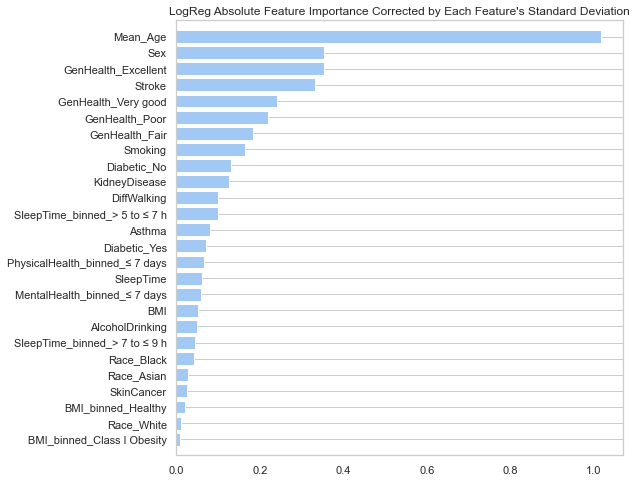

In [66]:
# adjusted for only magnitude
plt.figure(figsize=(8,8))
plot.feature_importances(abs(coef_* X_train.std(axis=0)), top_n=26, feature_names=feature_names)
plt.title("LogReg Absolute Feature Importance Corrected by Each Feature's Standard Deviation")
plt.show()

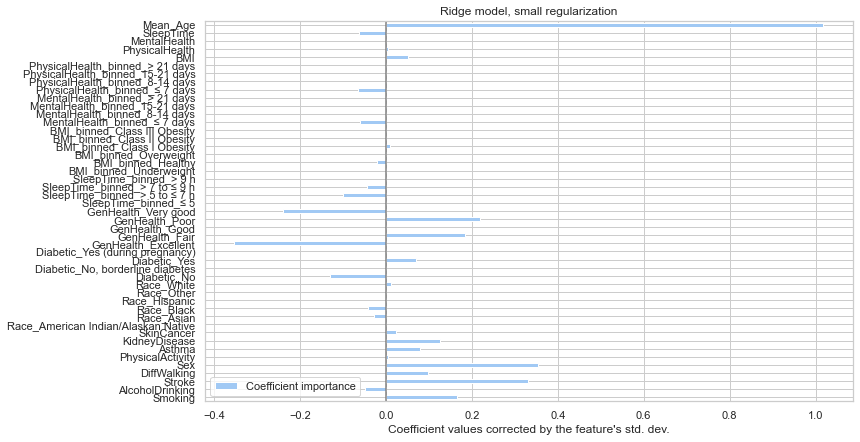

In [54]:
# plot coefs after scaling with standard deviation
coefs = pd.DataFrame(coef_ * X_train.std(axis=0), columns=["Coefficient importance"],index=feature_names)
coefs.plot(kind="barh", figsize=(15, 7))
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [55]:
feature_importances = feature_importances.sort_values(by='Coefficient importance', ascending=False)
feature_importances

,Coefficient importance
Mean_Age,1.018210
Sex,0.353388
Stroke,0.331126
GenHealth_Poor,0.218973
GenHealth_Fair,0.183217
Smoking,0.165201
KidneyDisease,0.126674
DiffWalking,0.098960
Asthma,0.080375
Diabetic_Yes,0.070647


**Begin testing**

Test selected feature groupings 

In [56]:
# features selected by RFE 
# LogReg model with lasso regularization (Lasso) 
rfelr = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear', scoring='accuracy', cv=StratifiedKFold(5), random_state=45, n_jobs=-1)
rfelr = rfelr.fit(RFElr_X_train, y_train)
rfey_pred = rfelr.predict(RFElr_X_test)

print('LogReg2 Lasso model: \n')
print(f'Confusion matrix: \n{confusion_matrix(y_test, rfey_pred)}\n')
print(f'Classification report: \n{classification_report(y_test, rfey_pred, digits=5)}')

# model evaluation against test set
rfey_hat = rfelr.predict(RFElr_X_train)
print(f'LogReg2 training set accuracy: {accuracy_score(y_train, rfey_hat)}')
print(f'LogReg2 test set accuracy: {accuracy_score(y_test, rfey_pred)}')

LogReg2 Lasso model: 

Confusion matrix: 
[[4188 1395]
 [1108 4259]]

Classification report: 
              precision    recall  f1-score   support

           0    0.79079   0.75013   0.76992      5583
           1    0.75327   0.79355   0.77289      5367

    accuracy                        0.77142     10950
   macro avg    0.77203   0.77184   0.77141     10950
weighted avg    0.77240   0.77142   0.77138     10950

LogReg2 training set accuracy: 0.7672230573842724
LogReg2 test set accuracy: 0.7714155251141552


In [57]:
# features selected by LogReg Lasso model as low importance removed 
# LogReg model with lasso regularization 
lr_zerolow = LogisticRegression(penalty='l1', solver='liblinear', random_state=45)
lr_zerolow = lr_zerolow.fit(important_X_train, y_train)
y_pred_zerolow = lr_zerolow.predict(important_X_test)

print('Important Features Only LogReg model: \n')
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred_zerolow)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_zerolow, digits=5)}')

# model evaluation against test set
y_hat_zerolow = lr_zerolow.predict(important_X_train)
print(f'Important Features Only training set accuracy: {accuracy_score(y_train, y_hat_zerolow)}')
print(f'Important Features Only test set accuracy: {accuracy_score(y_test, y_pred_zerolow)}')

Important Features Only LogReg model: 

Confusion matrix: 
[[4191 1392]
 [1125 4242]]

Classification report: 
              precision    recall  f1-score   support

           0    0.78837   0.75067   0.76906      5583
           1    0.75293   0.79039   0.77120      5367

    accuracy                        0.77014     10950
   macro avg    0.77065   0.77053   0.77013     10950
weighted avg    0.77100   0.77014   0.77011     10950

Important Features Only training set accuracy: 0.7674044891400135
Important Features Only test set accuracy: 0.7701369863013698


In [58]:
y_pred_zerolow_prob = lr_zerolow.predict_proba(important_X_test)
y_pred_zerolow_proba = [j for [i,j] in y_pred_zerolow_prob]

In [59]:
print(important_X_test.columns)

Index(['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'Asthma',
       'KidneyDisease', 'SkinCancer', 'Race_Asian', 'Race_Black',
       'Diabetic_No', 'Diabetic_Yes', 'GenHealth_Excellent', 'GenHealth_Fair',
       'GenHealth_Poor', 'GenHealth_Very good',
       'SleepTime_binned_> 5 to ≤ 7 h', 'SleepTime_binned_> 7 to ≤ 9 h',
       'MentalHealth_binned_≤ 7 days', 'PhysicalHealth_binned_≤ 7 days',
       'SleepTime', 'Mean_Age'],
      dtype='object')


In [60]:
# important features did not lead to higher accuracy

**Mean_Age Only Log Reg!**

In [71]:
# AGE ONLY Logistic Regression with l1 regularization (Lasso) 
lr2_age = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear', scoring='accuracy', cv=StratifiedKFold(5), random_state=45, n_jobs=-1)
lr2_age = lr2_age.fit(age_X_train, y_train)
y_pred2_age = lr2_age.predict(age_X_test)

print('Mean_Age Only LogReg2 Lasso model: \n')
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred2_age)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred2_age, digits=5)}')

# model evaluation against test set
y_hat_age = lr2_age.predict(age_X_train)
print(f'Mean_Age Only LogReg2 training set accuracy: {accuracy_score(y_train, y_hat_age)}')
print(f'Mean_Age Only LogReg2 test set accuracy: {accuracy_score(y_test, y_pred2_age)}')

Mean_Age Only LogReg2 Lasso model: 

Confusion matrix: 
[[3223 2360]
 [1086 4281]]

Classification report: 
              precision    recall  f1-score   support

           0    0.74797   0.57729   0.65164      5583
           1    0.64463   0.79765   0.71302      5367

    accuracy                        0.68530     10950
   macro avg    0.69630   0.68747   0.68233     10950
weighted avg    0.69732   0.68530   0.68173     10950

Mean_Age Only LogReg2 training set accuracy: 0.698019801980198
Mean_Age Only LogReg2 test set accuracy: 0.6852968036529681


PhysicalHealth, Mean_Age Only LogReg2 training set accuracy: 0.7251364053805845
PhysicalHealth, Mean_Age Only LogReg2 test set accuracy: 0.712054794520548

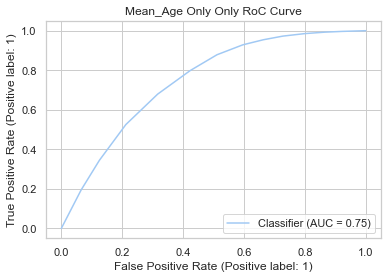

Mean_Age Only only ROC-AUC: 0.7473781420286857


In [72]:
y_pred2_age_prob = lr2_age.predict_proba(age_X_test)
y_pred2_age_proba = [j for [i,j] in y_pred2_age_prob]
age_roc_pred = RocCurveDisplay.from_predictions(y_test, y_pred2_age_proba)
plt.title("Mean_Age Only Only RoC Curve")
plt.show()

ras = roc_auc_score(y_test, y_pred2_age_proba)
print(f"Mean_Age Only only ROC-AUC: {ras}")

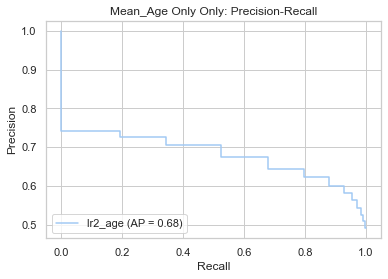

Mean_Age Only Only Precision-Recall AUC: 0.6804804775096305


In [73]:
average_precision = average_precision_score(y_test, y_pred2_age_proba, average="micro", pos_label=1)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred2_age_proba, pos_label=1)
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision, estimator_name="lr2_age")
disp.plot()
plt.title("Mean_Age Only Only: Precision-Recall")
plt.show()
pr_auc = average_precision_score(y_test, y_pred2_age_proba, pos_label=1)
print(f"Mean_Age Only Only Precision-Recall AUC: {pr_auc}")


In [74]:
## Test other models with feature selection 

**Random Forest**

In [75]:
grid_params = {'criterion' : ['gini', 'entropy'],
               'n_estimators' : list(range(1,500)),
               'max_depth': list(range(3, 20))}

rf_rs = RandomizedSearchCV(RandomForestClassifier(), grid_params, verbose=1, cv=5, n_jobs=-1)
rf = rf_rs.fit(X_train, y_train)

print(f'Best params: {rf.best_params_}')
print(f'Best score: {rf.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'n_estimators': 363, 'max_depth': 14, 'criterion': 'gini'}
Best score: 0.7670157374403075


In [76]:
# entropy Random Forest Classifier model, consider playing with max_depth. is that a hyperparameter?
rfc = RandomForestClassifier(criterion='entropy', n_estimators=362, max_depth=12, n_jobs=-1)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

print('Random Forest Entropy model \n')
print(f'Confusion matrix: \n {confusion_matrix(y_test,y_pred_rfc)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_rfc, digits=5)}')

# model evaluation against test set
y_hat = rfc.predict(X_train)
print(f'Random Forest training set accuracy: {accuracy_score(y_train, y_hat)}')
print(f'Random Forest test set accuracy: {accuracy_score(y_test, y_pred_rfc)}')

Random Forest Entropy model 

Confusion matrix: 
 [[3984 1599]
 [ 964 4403]]

Classification report: 
              precision    recall  f1-score   support

           0    0.80517   0.71359   0.75662      5583
           1    0.73359   0.82038   0.77456      5367

    accuracy                        0.76594     10950
   macro avg    0.76938   0.76699   0.76559     10950
weighted avg    0.77009   0.76594   0.76542     10950

Random Forest training set accuracy: 0.7981960499714893
Random Forest test set accuracy: 0.7659360730593607


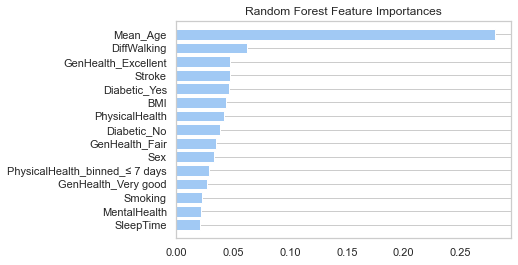

feature_name,importance
Mean_Age,0.280484
DiffWalking,0.0620463
GenHealth_Excellent,0.0473929
Stroke,0.0468203
Diabetic_Yes,0.046437
BMI,0.0433843
PhysicalHealth,0.0421581
Diabetic_No,0.0385253
GenHealth_Fair,0.0350771
Sex,0.0327572


In [77]:
# plot RandomForestClassifier feature importances
feature_names = list(rfc.feature_names_in_)
feature_importances = rfc.feature_importances_
plot.feature_importances(feature_importances, top_n=15, feature_names=feature_names)
plt.title('Random Forest Feature Importances')
plt.show()
# table of importances
table.feature_importances(feature_importances, feature_names=feature_names)

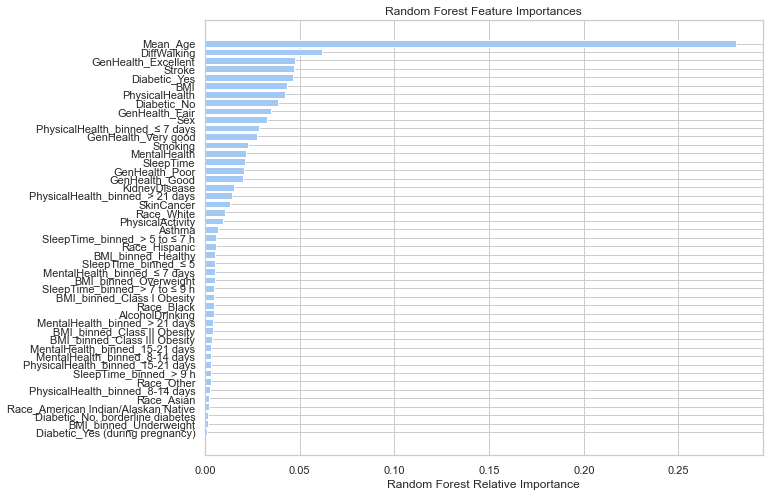

In [78]:
feature_names = list(rfc.feature_names_in_)
importances = rfc.feature_importances_
indices = np.argsort(importances)
fig, ax = plt.subplots(figsize=(10,8))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.title('Random Forest Feature Importances')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Random Forest Relative Importance')
plt.show()

In [79]:
# Random Forest selected features
rf_15_train = X_train[['Mean_Age', 'DiffWalking', 'GenHealth_Excellent',
                        'PhysicalHealth', 'Stroke', 'Diabetic_Yes', 'BMI',
                        'Diabetic_No', 'GenHealth_Fair', 'Sex', 'PhysicalHealth_binned_≤ 7 days',
                       'GenHealth_Very good', 'Smoking', 'GenHealth_Poor', 'MentalHealth']]
rf_15_test = X_test[['Mean_Age', 'DiffWalking', 'GenHealth_Excellent',
                        'PhysicalHealth', 'Stroke', 'Diabetic_Yes', 'BMI',
                        'Diabetic_No', 'GenHealth_Fair', 'Sex', 'PhysicalHealth_binned_≤ 7 days',
                     'GenHealth_Very good', 'Smoking', 'GenHealth_Poor', 'MentalHealth']]

In [80]:
rfc_15 = RandomForestClassifier(criterion='entropy', n_estimators=362, max_depth=12, n_jobs=-1)
rfc_15.fit(rf_15_train, y_train)
y_pred_rfc_15 = rfc_15.predict(rf_15_test)

print('Random Forest Entropy model \n')
print(f'Confusion matrix: \n {confusion_matrix(y_test,y_pred_rfc_15)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_rfc_15, digits=5)}')

# model evaluation against test set
y_hat_15 = rfc_15.predict(rf_15_train)
print(f'Random Forest training set accuracy: {accuracy_score(y_train, y_hat_15)}')
print(f'Random Forest test set accuracy: {accuracy_score(y_test, y_pred_rfc_15)}')

Random Forest Entropy model 

Confusion matrix: 
 [[3967 1616]
 [ 972 4395]]

Classification report: 
              precision    recall  f1-score   support

           0    0.80320   0.71055   0.75404      5583
           1    0.73116   0.81889   0.77254      5367

    accuracy                        0.76365     10950
   macro avg    0.76718   0.76472   0.76329     10950
weighted avg    0.76789   0.76365   0.76311     10950

Random Forest training set accuracy: 0.7986366699497175
Random Forest test set accuracy: 0.7636529680365297


In [81]:
# do I need to multiply through by standard deviation for feature importances?

In [82]:
# random forest a bit overfit on training set, nearly 80% accuracy but 76.42% on test set

**XGBoost**

In [83]:
from xgboost import XGBClassifier
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

xgb = XGBClassifier(use_label_encoder=False, random_state=123)
xgb = xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# evaluate xgb model
print('XGBoost model: \n')
print(f'Confusion matrix: \n {confusion_matrix(y_test,y_pred_xgb)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_xgb, digits=5)}')

[20:20:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost model: 

Confusion matrix: 
 [[4018 1565]
 [1071 4296]]

Classification report: 
              precision    recall  f1-score   support

           0    0.78955   0.71968   0.75300      5583
           1    0.73298   0.80045   0.76523      5367

    accuracy                        0.75927     10950
   macro avg    0.76126   0.76007   0.75911     10950
weighted avg    0.76182   0.75927   0.75899     10950



In [84]:
# XGB model evaluation against test set
y_hat = xgb.predict(X_train)
print(f'XGB training set accuracy: {accuracy_score(y_train, y_hat)}')
print(f'XGB test set accuracy: {accuracy_score(y_test, y_pred_xgb)}')

XGB training set accuracy: 0.8079674459592556
XGB test set accuracy: 0.759269406392694


XGB may be overfit with a higher training set accuracy than test set accuracy. 

In [85]:
# used RFECV to compute best XGB feature iterations
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

min_features_to_select=1
xgb_rfecv = RFECV(xgb, min_features_to_select=min_features_to_select, step=1, cv=StratifiedKFold(5),
    scoring='accuracy', n_jobs=-1)
xgb_rfecv.fit(X_train, y_train)
xgb_rfecv_feature_names_out = xgb_rfecv.get_feature_names_out()
xgb_status = xgb_rfecv.support_
xgb_rankings = xgb_rfecv.ranking_
xgb_best_features =  X_train[xgb_rfecv_feature_names_out]
print("XGB Optimal number of features : %d" % xgb_rfecv.n_features_)
print(f'XGB RFE selected features: \n{xgb_best_features.columns}')


/opt/homebrew/Caskroom/miniforge/base/envs/cloned/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/homebrew/Caskroom/miniforge/base/envs/cloned/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/homebrew/Caskroom/miniforge/base/envs/cloned/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/homebrew/Caskroom/miniforge/base/envs/cloned/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWar

[20:26:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:27:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

XGB RFECV chosen features:

Optimal number of features : 11
RFE selected features: 
Index(['Stroke', 'DiffWalking', 'Sex', 'Diabetic_No', 'Diabetic_Yes',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good', 'Mean_Age']

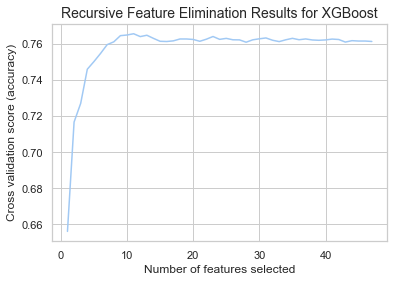

In [86]:
# plot XGB RFECV cv_scores_
plt.figure()
plt.title('Recursive Feature Elimination Results for XGBoost', fontsize=14)
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (accuracy)')
plt.plot(range(min_features_to_select, 
               (len(xgb_rfecv.cv_results_['mean_test_score']) + min_features_to_select)),
         xgb_rfecv.cv_results_['mean_test_score'],)
plt.show()

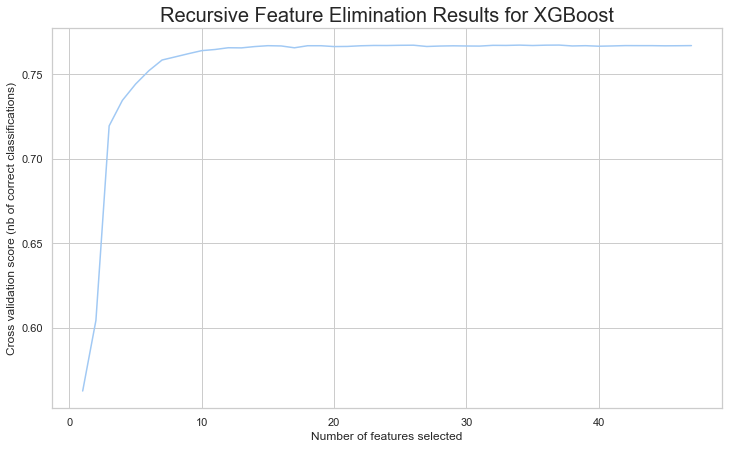

In [87]:
plt.figure(figsize=(12,7))
_ = plt.title('Recursive Feature Elimination Results for XGBoost', fontsize=20)
_ = plt.xlabel('Number of features selected')
_ = plt.ylabel('Cross validation score (nb of correct classifications)')
_ = plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
_ = plt.show()

In [88]:
xgb_X_train = X_train[['Stroke', 'DiffWalking', 'Sex', 'Diabetic_No', 'Diabetic_Yes',
                       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good', 
                       'GenHealth_Poor', 'GenHealth_Very good', 'Mean_Age']]
xgb_X_test = X_test[['Stroke', 'DiffWalking', 'Sex', 'Diabetic_No', 'Diabetic_Yes',
                      'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
                      'GenHealth_Poor', 'GenHealth_Very good', 'Mean_Age']]

In [89]:
# XGBoost using selected XGB features
xgb2 = XGBClassifier(use_label_encoder=False, random_state=123)
xgb2 = xgb2.fit(xgb_X_train, y_train)
y_pred_xgb2 = xgb2.predict(xgb_X_test)

# evaluate xgb2 model
print('XGBoost model with Selected Features: \n')
print(f'Confusion matrix: \n {confusion_matrix(y_test,y_pred_xgb2)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_xgb2, digits=5)}')


# model evaluation against test set
xgb2_y_hat = xgb2.predict(xgb_X_train)
print(f'XGB2 training set accuracy: {accuracy_score(y_train, xgb2_y_hat)}')
print(f'XGB2 test set accuracy: {accuracy_score(y_test, y_pred_xgb2)}')

[20:27:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost model with Selected Features: 

Confusion matrix: 
 [[3954 1629]
 [ 968 4399]]

Classification report: 
              precision    recall  f1-score   support

           0    0.80333   0.70822   0.75278      5583
           1    0.72976   0.81964   0.77209      5367

    accuracy                        0.76283     10950
   macro avg    0.76655   0.76393   0.76244     10950
weighted avg    0.76727   0.76283   0.76225     10950

XGB2 training set accuracy: 0.7714478254108134
XGB2 test set accuracy: 0.7628310502283105
[20:20:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd l

[20:20:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:20:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [ ]:
# XGBoost significantly better at predicting 0 class than 1 class 
# Using XGB selected features limits overfitting on the training set 
# and increases accuracy somewhat